# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.9KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

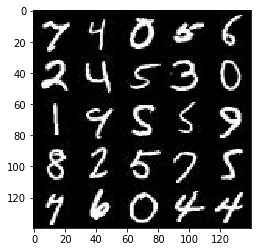

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

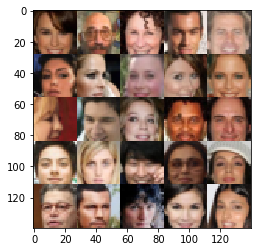

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    data_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return (input_images, data_z, learning_rate)

   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        normal2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * normal2, normal2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        normal3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * normal3, normal3)
        
        reshaping=4*4*256
        flat = tf.reshape(relu3, (-1, reshaping))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)


    return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fcc1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        fcc1 = tf.reshape(fcc1, (-1, 7, 7, 256))
        normal1 = tf.layers.batch_normalization(fcc1, training=is_train)
        max1 = tf.maximum(alpha * normal1, normal1)
        
        conv2 = tf.layers.conv2d_transpose(max1, 128, 5, strides=2, padding='same')
        normal2 = tf.layers.batch_normalization(conv2, training=is_train)
        max2 = tf.maximum(alpha * normal2, normal2)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(max2, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        
    return output 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs( data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #optimize d_opt
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #optimize g_opt
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25, input_z, data_shape[3], data_image_mode)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 2.9447... Generator Loss: 0.1234
Epoch 0/2... Discriminator Loss: 1.9681... Generator Loss: 0.2146
Epoch 0/2... Discriminator Loss: 1.5615... Generator Loss: 0.5060
Epoch 0/2... Discriminator Loss: 1.8807... Generator Loss: 0.3843
Epoch 0/2... Discriminator Loss: 1.7655... Generator Loss: 0.6033
Epoch 0/2... Discriminator Loss: 2.2967... Generator Loss: 0.1438
Epoch 0/2... Discriminator Loss: 1.8312... Generator Loss: 0.2546
Epoch 0/2... Discriminator Loss: 1.9727... Generator Loss: 0.2049
Epoch 0/2... Discriminator Loss: 1.7158... Generator Loss: 0.5504
Epoch 0/2... Discriminator Loss: 2.0708... Generator Loss: 0.2074


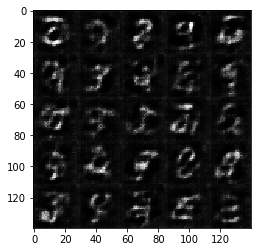

Epoch 0/2... Discriminator Loss: 1.5656... Generator Loss: 0.3692
Epoch 0/2... Discriminator Loss: 1.7242... Generator Loss: 0.2984
Epoch 0/2... Discriminator Loss: 1.7421... Generator Loss: 0.2905
Epoch 0/2... Discriminator Loss: 1.6090... Generator Loss: 0.3312
Epoch 0/2... Discriminator Loss: 1.4953... Generator Loss: 0.5188
Epoch 0/2... Discriminator Loss: 1.4818... Generator Loss: 0.7779
Epoch 0/2... Discriminator Loss: 1.6014... Generator Loss: 0.9720
Epoch 0/2... Discriminator Loss: 1.8076... Generator Loss: 0.2912
Epoch 0/2... Discriminator Loss: 1.6194... Generator Loss: 0.5114
Epoch 0/2... Discriminator Loss: 1.4594... Generator Loss: 0.8662


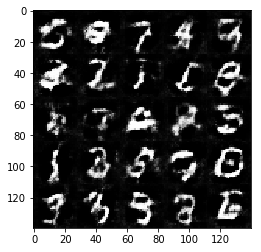

Epoch 0/2... Discriminator Loss: 1.9934... Generator Loss: 0.1835
Epoch 0/2... Discriminator Loss: 1.5292... Generator Loss: 0.6894
Epoch 0/2... Discriminator Loss: 1.4408... Generator Loss: 0.4840
Epoch 0/2... Discriminator Loss: 1.3343... Generator Loss: 0.8428
Epoch 0/2... Discriminator Loss: 1.5130... Generator Loss: 0.7585
Epoch 0/2... Discriminator Loss: 1.4827... Generator Loss: 0.7533
Epoch 0/2... Discriminator Loss: 1.5438... Generator Loss: 0.3770
Epoch 0/2... Discriminator Loss: 1.7032... Generator Loss: 0.2823
Epoch 0/2... Discriminator Loss: 1.4397... Generator Loss: 0.8753
Epoch 0/2... Discriminator Loss: 1.8566... Generator Loss: 0.2209


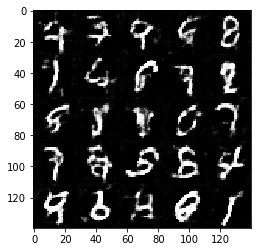

Epoch 0/2... Discriminator Loss: 1.4159... Generator Loss: 0.7887
Epoch 0/2... Discriminator Loss: 1.8009... Generator Loss: 0.2312
Epoch 0/2... Discriminator Loss: 1.8933... Generator Loss: 0.2139
Epoch 0/2... Discriminator Loss: 1.5565... Generator Loss: 0.4500
Epoch 0/2... Discriminator Loss: 1.5223... Generator Loss: 0.4667
Epoch 0/2... Discriminator Loss: 2.1593... Generator Loss: 0.1577
Epoch 0/2... Discriminator Loss: 1.3983... Generator Loss: 0.5772
Epoch 0/2... Discriminator Loss: 1.6462... Generator Loss: 0.2835
Epoch 0/2... Discriminator Loss: 1.5712... Generator Loss: 0.4161
Epoch 0/2... Discriminator Loss: 1.3832... Generator Loss: 0.7301


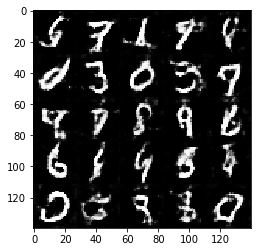

Epoch 0/2... Discriminator Loss: 1.6523... Generator Loss: 0.3049
Epoch 0/2... Discriminator Loss: 1.8032... Generator Loss: 0.2523
Epoch 0/2... Discriminator Loss: 1.5704... Generator Loss: 0.3444
Epoch 0/2... Discriminator Loss: 1.7557... Generator Loss: 0.2749
Epoch 0/2... Discriminator Loss: 1.4835... Generator Loss: 0.4084
Epoch 0/2... Discriminator Loss: 1.4555... Generator Loss: 0.7509
Epoch 0/2... Discriminator Loss: 1.6102... Generator Loss: 0.3214
Epoch 0/2... Discriminator Loss: 2.0088... Generator Loss: 0.1812
Epoch 0/2... Discriminator Loss: 1.2552... Generator Loss: 0.4893
Epoch 0/2... Discriminator Loss: 2.2939... Generator Loss: 0.1427


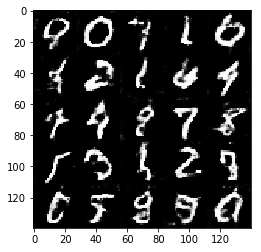

Epoch 0/2... Discriminator Loss: 1.4646... Generator Loss: 0.5820
Epoch 0/2... Discriminator Loss: 1.5181... Generator Loss: 0.4449
Epoch 0/2... Discriminator Loss: 1.3755... Generator Loss: 0.5735
Epoch 0/2... Discriminator Loss: 1.3880... Generator Loss: 0.4545
Epoch 0/2... Discriminator Loss: 1.8060... Generator Loss: 0.2383
Epoch 0/2... Discriminator Loss: 1.5957... Generator Loss: 0.3164
Epoch 0/2... Discriminator Loss: 1.4739... Generator Loss: 0.4556
Epoch 0/2... Discriminator Loss: 1.7649... Generator Loss: 0.3807
Epoch 0/2... Discriminator Loss: 1.6356... Generator Loss: 0.4118
Epoch 0/2... Discriminator Loss: 1.5269... Generator Loss: 0.4651


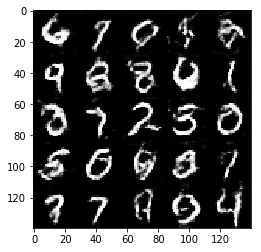

Epoch 0/2... Discriminator Loss: 1.6014... Generator Loss: 0.4362
Epoch 0/2... Discriminator Loss: 1.4953... Generator Loss: 0.5376
Epoch 0/2... Discriminator Loss: 2.1896... Generator Loss: 0.1669
Epoch 0/2... Discriminator Loss: 1.5531... Generator Loss: 0.3954
Epoch 0/2... Discriminator Loss: 1.8927... Generator Loss: 1.4993
Epoch 0/2... Discriminator Loss: 1.5284... Generator Loss: 0.5226
Epoch 0/2... Discriminator Loss: 1.9104... Generator Loss: 0.2297
Epoch 0/2... Discriminator Loss: 1.4521... Generator Loss: 0.3977
Epoch 0/2... Discriminator Loss: 1.4387... Generator Loss: 0.4337
Epoch 0/2... Discriminator Loss: 1.8313... Generator Loss: 0.2373


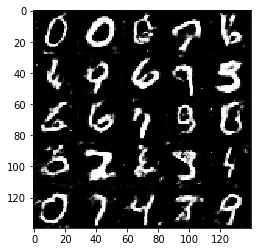

Epoch 0/2... Discriminator Loss: 1.7392... Generator Loss: 0.2673
Epoch 0/2... Discriminator Loss: 1.4579... Generator Loss: 0.5084
Epoch 0/2... Discriminator Loss: 1.8841... Generator Loss: 0.2375
Epoch 0/2... Discriminator Loss: 1.7575... Generator Loss: 0.3152
Epoch 0/2... Discriminator Loss: 1.4645... Generator Loss: 0.5435
Epoch 0/2... Discriminator Loss: 1.5279... Generator Loss: 0.4112
Epoch 0/2... Discriminator Loss: 1.3281... Generator Loss: 0.6373
Epoch 0/2... Discriminator Loss: 2.3042... Generator Loss: 0.1350
Epoch 0/2... Discriminator Loss: 2.2045... Generator Loss: 0.1595
Epoch 0/2... Discriminator Loss: 2.1346... Generator Loss: 0.1735


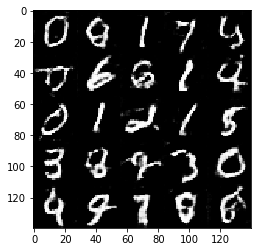

Epoch 0/2... Discriminator Loss: 1.7598... Generator Loss: 0.2882
Epoch 0/2... Discriminator Loss: 2.1515... Generator Loss: 0.2140
Epoch 0/2... Discriminator Loss: 1.5260... Generator Loss: 0.4400
Epoch 0/2... Discriminator Loss: 1.4587... Generator Loss: 0.5293
Epoch 0/2... Discriminator Loss: 1.6875... Generator Loss: 0.3025
Epoch 0/2... Discriminator Loss: 1.6989... Generator Loss: 0.3090
Epoch 0/2... Discriminator Loss: 1.2071... Generator Loss: 0.8467
Epoch 0/2... Discriminator Loss: 1.2100... Generator Loss: 0.9027
Epoch 0/2... Discriminator Loss: 1.3977... Generator Loss: 1.0204
Epoch 0/2... Discriminator Loss: 1.6779... Generator Loss: 0.3029


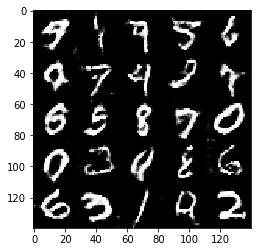

Epoch 0/2... Discriminator Loss: 1.2798... Generator Loss: 0.5376
Epoch 0/2... Discriminator Loss: 1.7689... Generator Loss: 0.2716
Epoch 0/2... Discriminator Loss: 3.2332... Generator Loss: 0.0635
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.9911... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.2091
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 2.0678... Generator Loss: 0.1895
Epoch 1/2... Discriminator Loss: 2.0785... Generator Loss: 0.2060
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.4953


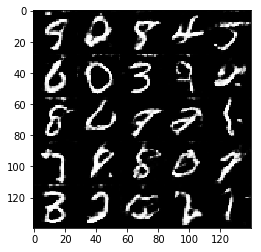

Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.3049
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.3128
Epoch 1/2... Discriminator Loss: 2.3333... Generator Loss: 0.1382
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.5135... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.7606... Generator Loss: 0.2646
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.5106


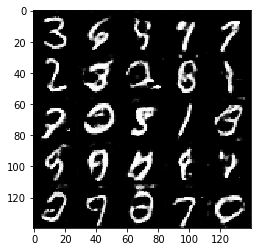

Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 2.0143... Generator Loss: 0.2287
Epoch 1/2... Discriminator Loss: 1.9219... Generator Loss: 0.2553
Epoch 1/2... Discriminator Loss: 1.6836... Generator Loss: 0.3342
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 2.0030... Generator Loss: 0.2343
Epoch 1/2... Discriminator Loss: 1.7374... Generator Loss: 0.3266


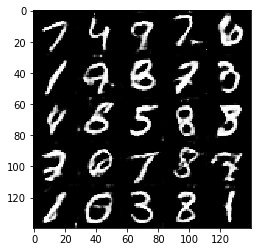

Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 0.3265
Epoch 1/2... Discriminator Loss: 2.4903... Generator Loss: 3.4694
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 2.0326... Generator Loss: 0.2125
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 0.3957
Epoch 1/2... Discriminator Loss: 2.3133... Generator Loss: 0.1437
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.5245
Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.3325
Epoch 1/2... Discriminator Loss: 2.0069... Generator Loss: 0.2320
Epoch 1/2... Discriminator Loss: 2.3088... Generator Loss: 0.1624


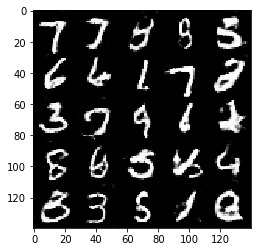

Epoch 1/2... Discriminator Loss: 2.0986... Generator Loss: 0.2329
Epoch 1/2... Discriminator Loss: 2.6801... Generator Loss: 0.1080
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.3134
Epoch 1/2... Discriminator Loss: 2.7187... Generator Loss: 0.1106
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 2.7887... Generator Loss: 0.1299
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.6986
Epoch 1/2... Discriminator Loss: 1.8223... Generator Loss: 0.2928


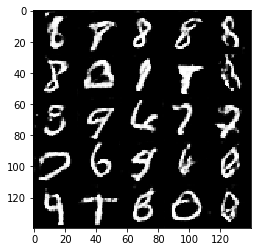

Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 1.2547
Epoch 1/2... Discriminator Loss: 1.7587... Generator Loss: 0.2970
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.4504
Epoch 1/2... Discriminator Loss: 2.5219... Generator Loss: 0.1787
Epoch 1/2... Discriminator Loss: 1.6090... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 1.6515... Generator Loss: 0.3561


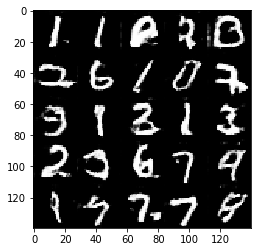

Epoch 1/2... Discriminator Loss: 2.0339... Generator Loss: 0.2000
Epoch 1/2... Discriminator Loss: 1.8860... Generator Loss: 1.8036
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.5521... Generator Loss: 1.6529
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.9374... Generator Loss: 0.2403
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.2883
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.3475
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.4747


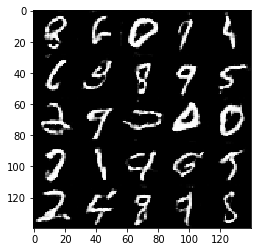

Epoch 1/2... Discriminator Loss: 1.6385... Generator Loss: 0.3514
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.7830... Generator Loss: 0.2871
Epoch 1/2... Discriminator Loss: 2.1854... Generator Loss: 0.1903
Epoch 1/2... Discriminator Loss: 1.8563... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 2.6112... Generator Loss: 0.1679
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.4274
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 2.3441... Generator Loss: 0.2182
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.6137


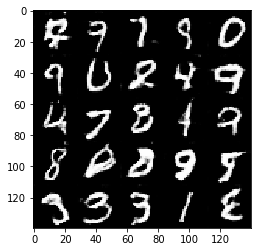

Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 0.3206
Epoch 1/2... Discriminator Loss: 1.8179... Generator Loss: 0.3014
Epoch 1/2... Discriminator Loss: 2.4713... Generator Loss: 0.1598
Epoch 1/2... Discriminator Loss: 1.6246... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 2.3721
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 2.3812... Generator Loss: 0.1718
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.4537


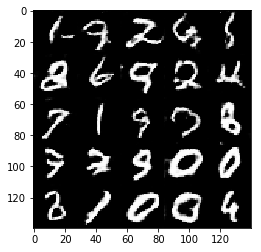

Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 0.3209
Epoch 1/2... Discriminator Loss: 1.7994... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 1.7181... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 1.9262... Generator Loss: 0.2487
Epoch 1/2... Discriminator Loss: 2.3246... Generator Loss: 0.1729
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.4436


In [25]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.9003... Generator Loss: 0.2599
Epoch 0/1... Discriminator Loss: 1.3498... Generator Loss: 0.4469
Epoch 0/1... Discriminator Loss: 1.2029... Generator Loss: 0.4728
Epoch 0/1... Discriminator Loss: 1.0423... Generator Loss: 0.6116
Epoch 0/1... Discriminator Loss: 0.5927... Generator Loss: 1.2381
Epoch 0/1... Discriminator Loss: 0.8656... Generator Loss: 1.2393
Epoch 0/1... Discriminator Loss: 1.1175... Generator Loss: 0.6784
Epoch 0/1... Discriminator Loss: 1.2061... Generator Loss: 0.9185
Epoch 0/1... Discriminator Loss: 1.0552... Generator Loss: 0.7993
Epoch 0/1... Discriminator Loss: 1.4375... Generator Loss: 0.5303


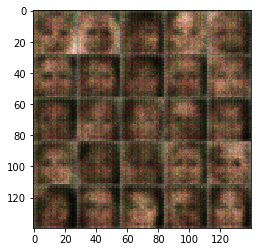

Epoch 0/1... Discriminator Loss: 1.7163... Generator Loss: 0.2950
Epoch 0/1... Discriminator Loss: 1.2313... Generator Loss: 0.7139
Epoch 0/1... Discriminator Loss: 1.1908... Generator Loss: 0.6760
Epoch 0/1... Discriminator Loss: 1.2368... Generator Loss: 0.5538
Epoch 0/1... Discriminator Loss: 1.2462... Generator Loss: 0.5144
Epoch 0/1... Discriminator Loss: 1.2452... Generator Loss: 0.6533
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.7165
Epoch 0/1... Discriminator Loss: 1.3886... Generator Loss: 0.5615
Epoch 0/1... Discriminator Loss: 1.3827... Generator Loss: 0.6463
Epoch 0/1... Discriminator Loss: 0.9225... Generator Loss: 0.9851


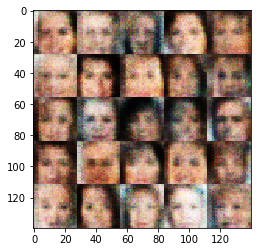

Epoch 0/1... Discriminator Loss: 1.0585... Generator Loss: 0.6650
Epoch 0/1... Discriminator Loss: 1.1516... Generator Loss: 0.6459
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 0.7292
Epoch 0/1... Discriminator Loss: 1.3368... Generator Loss: 0.4626
Epoch 0/1... Discriminator Loss: 1.2535... Generator Loss: 0.6662
Epoch 0/1... Discriminator Loss: 1.4037... Generator Loss: 0.5606
Epoch 0/1... Discriminator Loss: 1.1796... Generator Loss: 0.6139
Epoch 0/1... Discriminator Loss: 1.3439... Generator Loss: 0.5455
Epoch 0/1... Discriminator Loss: 1.0560... Generator Loss: 0.9976
Epoch 0/1... Discriminator Loss: 1.2373... Generator Loss: 0.7089


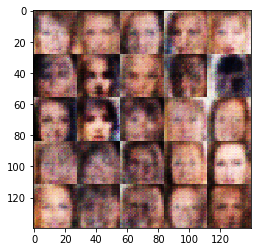

Epoch 0/1... Discriminator Loss: 1.5433... Generator Loss: 0.4098
Epoch 0/1... Discriminator Loss: 1.7823... Generator Loss: 0.2952
Epoch 0/1... Discriminator Loss: 1.3958... Generator Loss: 0.4922
Epoch 0/1... Discriminator Loss: 1.4697... Generator Loss: 0.4411
Epoch 0/1... Discriminator Loss: 1.4470... Generator Loss: 0.5102
Epoch 0/1... Discriminator Loss: 1.2826... Generator Loss: 0.8835
Epoch 0/1... Discriminator Loss: 1.3368... Generator Loss: 0.5660
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.5643
Epoch 0/1... Discriminator Loss: 1.4634... Generator Loss: 0.4430
Epoch 0/1... Discriminator Loss: 1.3983... Generator Loss: 0.6290


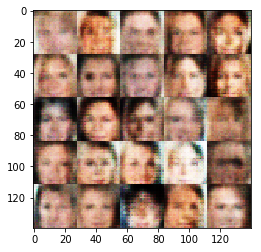

Epoch 0/1... Discriminator Loss: 1.3105... Generator Loss: 0.6487
Epoch 0/1... Discriminator Loss: 1.4997... Generator Loss: 0.7847
Epoch 0/1... Discriminator Loss: 1.5923... Generator Loss: 0.4275
Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 0.6497
Epoch 0/1... Discriminator Loss: 1.2541... Generator Loss: 0.7899
Epoch 0/1... Discriminator Loss: 1.3701... Generator Loss: 0.5498
Epoch 0/1... Discriminator Loss: 1.4693... Generator Loss: 0.5094
Epoch 0/1... Discriminator Loss: 1.3008... Generator Loss: 0.7325
Epoch 0/1... Discriminator Loss: 1.2399... Generator Loss: 0.6855
Epoch 0/1... Discriminator Loss: 1.5386... Generator Loss: 0.6082


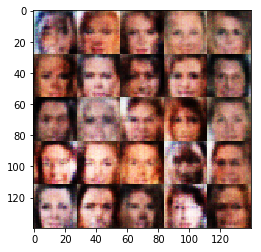

Epoch 0/1... Discriminator Loss: 1.4104... Generator Loss: 0.7589
Epoch 0/1... Discriminator Loss: 1.3024... Generator Loss: 0.7558
Epoch 0/1... Discriminator Loss: 1.3536... Generator Loss: 0.6117
Epoch 0/1... Discriminator Loss: 1.2899... Generator Loss: 0.6763
Epoch 0/1... Discriminator Loss: 1.4735... Generator Loss: 0.5205
Epoch 0/1... Discriminator Loss: 1.4391... Generator Loss: 0.5463
Epoch 0/1... Discriminator Loss: 1.5485... Generator Loss: 0.4438
Epoch 0/1... Discriminator Loss: 1.3751... Generator Loss: 0.8265
Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.6323
Epoch 0/1... Discriminator Loss: 1.2934... Generator Loss: 0.7254


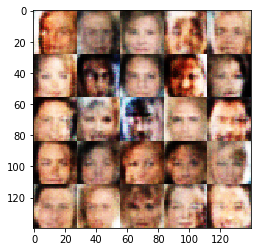

Epoch 0/1... Discriminator Loss: 1.2974... Generator Loss: 0.6262
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.6806
Epoch 0/1... Discriminator Loss: 1.4210... Generator Loss: 0.7118
Epoch 0/1... Discriminator Loss: 1.5440... Generator Loss: 0.6278
Epoch 0/1... Discriminator Loss: 1.3238... Generator Loss: 0.8378
Epoch 0/1... Discriminator Loss: 1.2817... Generator Loss: 0.6938
Epoch 0/1... Discriminator Loss: 1.2976... Generator Loss: 0.6670
Epoch 0/1... Discriminator Loss: 1.3961... Generator Loss: 0.5844
Epoch 0/1... Discriminator Loss: 1.3722... Generator Loss: 0.7175
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.6330


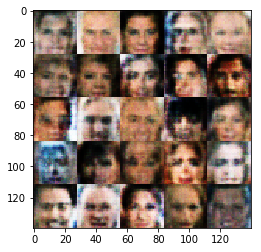

Epoch 0/1... Discriminator Loss: 1.3452... Generator Loss: 0.5934
Epoch 0/1... Discriminator Loss: 1.3409... Generator Loss: 0.6578
Epoch 0/1... Discriminator Loss: 1.5379... Generator Loss: 0.4633
Epoch 0/1... Discriminator Loss: 1.3551... Generator Loss: 0.5453
Epoch 0/1... Discriminator Loss: 1.4765... Generator Loss: 0.5002
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 0.8463
Epoch 0/1... Discriminator Loss: 1.2947... Generator Loss: 0.7610
Epoch 0/1... Discriminator Loss: 1.3581... Generator Loss: 0.7589
Epoch 0/1... Discriminator Loss: 1.3607... Generator Loss: 0.5704
Epoch 0/1... Discriminator Loss: 1.4674... Generator Loss: 0.5779


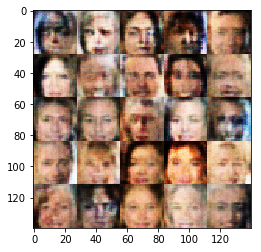

Epoch 0/1... Discriminator Loss: 1.2009... Generator Loss: 0.7540
Epoch 0/1... Discriminator Loss: 1.3244... Generator Loss: 0.8698
Epoch 0/1... Discriminator Loss: 1.3024... Generator Loss: 0.5685
Epoch 0/1... Discriminator Loss: 1.2986... Generator Loss: 0.7210
Epoch 0/1... Discriminator Loss: 1.2489... Generator Loss: 0.7267
Epoch 0/1... Discriminator Loss: 1.2413... Generator Loss: 0.7689
Epoch 0/1... Discriminator Loss: 1.3834... Generator Loss: 0.6397
Epoch 0/1... Discriminator Loss: 1.3953... Generator Loss: 0.6292
Epoch 0/1... Discriminator Loss: 1.2824... Generator Loss: 0.6980
Epoch 0/1... Discriminator Loss: 1.2611... Generator Loss: 0.7120


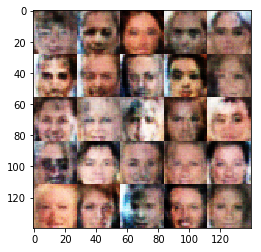

Epoch 0/1... Discriminator Loss: 1.3279... Generator Loss: 0.5765
Epoch 0/1... Discriminator Loss: 1.3535... Generator Loss: 0.5766
Epoch 0/1... Discriminator Loss: 1.3379... Generator Loss: 0.6067
Epoch 0/1... Discriminator Loss: 1.3538... Generator Loss: 0.5712
Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.5054
Epoch 0/1... Discriminator Loss: 1.4594... Generator Loss: 0.5187
Epoch 0/1... Discriminator Loss: 1.3925... Generator Loss: 0.5652
Epoch 0/1... Discriminator Loss: 1.3016... Generator Loss: 0.6455
Epoch 0/1... Discriminator Loss: 1.1781... Generator Loss: 0.6929
Epoch 0/1... Discriminator Loss: 1.4944... Generator Loss: 0.5900


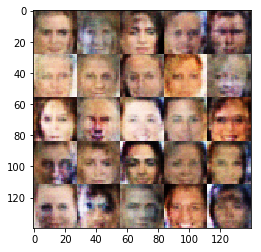

Epoch 0/1... Discriminator Loss: 1.3213... Generator Loss: 0.5813
Epoch 0/1... Discriminator Loss: 1.3295... Generator Loss: 0.6226
Epoch 0/1... Discriminator Loss: 1.2369... Generator Loss: 0.7837
Epoch 0/1... Discriminator Loss: 1.4701... Generator Loss: 0.4360
Epoch 0/1... Discriminator Loss: 1.1688... Generator Loss: 0.7464
Epoch 0/1... Discriminator Loss: 1.1954... Generator Loss: 0.7759
Epoch 0/1... Discriminator Loss: 1.1392... Generator Loss: 0.8377
Epoch 0/1... Discriminator Loss: 1.7604... Generator Loss: 0.3199
Epoch 0/1... Discriminator Loss: 1.2812... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.2523... Generator Loss: 0.6731


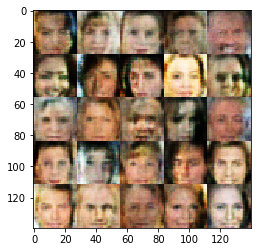

Epoch 0/1... Discriminator Loss: 1.4741... Generator Loss: 0.5303
Epoch 0/1... Discriminator Loss: 1.2974... Generator Loss: 0.5695
Epoch 0/1... Discriminator Loss: 1.4146... Generator Loss: 0.5321
Epoch 0/1... Discriminator Loss: 1.4495... Generator Loss: 0.5462
Epoch 0/1... Discriminator Loss: 1.4608... Generator Loss: 0.5922
Epoch 0/1... Discriminator Loss: 1.3163... Generator Loss: 0.4798
Epoch 0/1... Discriminator Loss: 1.2569... Generator Loss: 0.5953
Epoch 0/1... Discriminator Loss: 1.9768... Generator Loss: 0.2670
Epoch 0/1... Discriminator Loss: 1.3771... Generator Loss: 0.5002
Epoch 0/1... Discriminator Loss: 1.3058... Generator Loss: 0.5895


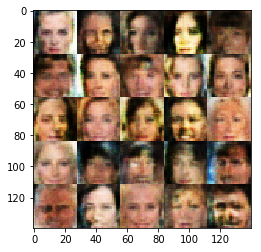

Epoch 0/1... Discriminator Loss: 1.1955... Generator Loss: 0.7623
Epoch 0/1... Discriminator Loss: 1.3864... Generator Loss: 0.5976
Epoch 0/1... Discriminator Loss: 1.4304... Generator Loss: 0.5324
Epoch 0/1... Discriminator Loss: 1.3094... Generator Loss: 0.5734
Epoch 0/1... Discriminator Loss: 1.4230... Generator Loss: 0.5710
Epoch 0/1... Discriminator Loss: 1.6074... Generator Loss: 0.5596
Epoch 0/1... Discriminator Loss: 1.3712... Generator Loss: 0.5508
Epoch 0/1... Discriminator Loss: 1.2433... Generator Loss: 0.5791
Epoch 0/1... Discriminator Loss: 1.5807... Generator Loss: 0.3912
Epoch 0/1... Discriminator Loss: 1.6199... Generator Loss: 0.4589


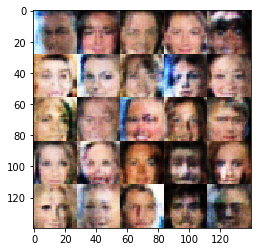

Epoch 0/1... Discriminator Loss: 1.2331... Generator Loss: 0.6098
Epoch 0/1... Discriminator Loss: 1.3670... Generator Loss: 0.5672
Epoch 0/1... Discriminator Loss: 1.4910... Generator Loss: 0.4760
Epoch 0/1... Discriminator Loss: 1.4209... Generator Loss: 0.4848
Epoch 0/1... Discriminator Loss: 1.2579... Generator Loss: 0.7792
Epoch 0/1... Discriminator Loss: 1.4716... Generator Loss: 0.4500
Epoch 0/1... Discriminator Loss: 1.5845... Generator Loss: 0.4565
Epoch 0/1... Discriminator Loss: 1.2045... Generator Loss: 0.6312
Epoch 0/1... Discriminator Loss: 1.6381... Generator Loss: 0.4281
Epoch 0/1... Discriminator Loss: 1.3310... Generator Loss: 0.7210


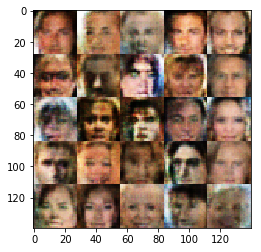

Epoch 0/1... Discriminator Loss: 1.3867... Generator Loss: 0.5952
Epoch 0/1... Discriminator Loss: 1.2397... Generator Loss: 0.6717
Epoch 0/1... Discriminator Loss: 1.4957... Generator Loss: 0.4826
Epoch 0/1... Discriminator Loss: 1.4680... Generator Loss: 0.5242
Epoch 0/1... Discriminator Loss: 1.6132... Generator Loss: 0.4293
Epoch 0/1... Discriminator Loss: 1.4498... Generator Loss: 0.4497
Epoch 0/1... Discriminator Loss: 1.4170... Generator Loss: 0.6439
Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.6211
Epoch 0/1... Discriminator Loss: 1.1995... Generator Loss: 0.6317
Epoch 0/1... Discriminator Loss: 1.3550... Generator Loss: 0.5589


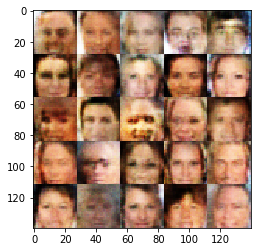

Epoch 0/1... Discriminator Loss: 1.5039... Generator Loss: 0.5310
Epoch 0/1... Discriminator Loss: 1.6657... Generator Loss: 0.4572
Epoch 0/1... Discriminator Loss: 1.4201... Generator Loss: 0.8158
Epoch 0/1... Discriminator Loss: 1.2879... Generator Loss: 0.7331
Epoch 0/1... Discriminator Loss: 1.5316... Generator Loss: 0.4170
Epoch 0/1... Discriminator Loss: 1.3981... Generator Loss: 0.8093
Epoch 0/1... Discriminator Loss: 1.2869... Generator Loss: 0.6195
Epoch 0/1... Discriminator Loss: 1.1937... Generator Loss: 0.7261
Epoch 0/1... Discriminator Loss: 1.3882... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 1.3359... Generator Loss: 0.5313


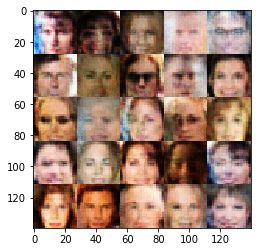

Epoch 0/1... Discriminator Loss: 1.4409... Generator Loss: 0.6117
Epoch 0/1... Discriminator Loss: 1.5518... Generator Loss: 0.5721
Epoch 0/1... Discriminator Loss: 1.5034... Generator Loss: 0.4323
Epoch 0/1... Discriminator Loss: 1.4451... Generator Loss: 0.4927
Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 0.5194
Epoch 0/1... Discriminator Loss: 1.4524... Generator Loss: 0.4969
Epoch 0/1... Discriminator Loss: 1.3029... Generator Loss: 0.4681
Epoch 0/1... Discriminator Loss: 1.6330... Generator Loss: 0.3731
Epoch 0/1... Discriminator Loss: 1.4378... Generator Loss: 0.5381
Epoch 0/1... Discriminator Loss: 1.3575... Generator Loss: 0.6060


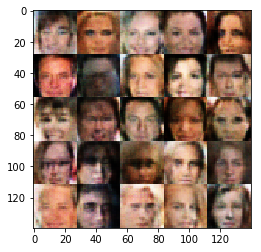

Epoch 0/1... Discriminator Loss: 1.1947... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 1.4613... Generator Loss: 0.4946
Epoch 0/1... Discriminator Loss: 1.5274... Generator Loss: 0.4032
Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 0.6462
Epoch 0/1... Discriminator Loss: 1.3255... Generator Loss: 0.6557
Epoch 0/1... Discriminator Loss: 1.4166... Generator Loss: 0.4804
Epoch 0/1... Discriminator Loss: 1.3117... Generator Loss: 0.6468
Epoch 0/1... Discriminator Loss: 1.3928... Generator Loss: 0.6219
Epoch 0/1... Discriminator Loss: 1.3479... Generator Loss: 0.7512
Epoch 0/1... Discriminator Loss: 1.6370... Generator Loss: 0.4349


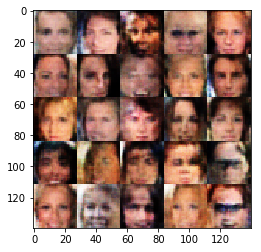

Epoch 0/1... Discriminator Loss: 1.4797... Generator Loss: 0.4516
Epoch 0/1... Discriminator Loss: 1.2302... Generator Loss: 0.6050
Epoch 0/1... Discriminator Loss: 1.2461... Generator Loss: 0.6190
Epoch 0/1... Discriminator Loss: 1.3694... Generator Loss: 0.5530
Epoch 0/1... Discriminator Loss: 1.3833... Generator Loss: 0.7699
Epoch 0/1... Discriminator Loss: 1.4672... Generator Loss: 0.4371
Epoch 0/1... Discriminator Loss: 1.4224... Generator Loss: 0.4676
Epoch 0/1... Discriminator Loss: 1.3400... Generator Loss: 0.5651
Epoch 0/1... Discriminator Loss: 1.3123... Generator Loss: 0.7074
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.5159


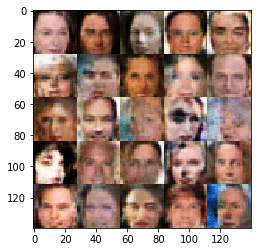

Epoch 0/1... Discriminator Loss: 1.6908... Generator Loss: 0.3480
Epoch 0/1... Discriminator Loss: 1.4953... Generator Loss: 0.4655
Epoch 0/1... Discriminator Loss: 1.2871... Generator Loss: 0.5961
Epoch 0/1... Discriminator Loss: 1.3450... Generator Loss: 0.4849
Epoch 0/1... Discriminator Loss: 1.6182... Generator Loss: 0.4769
Epoch 0/1... Discriminator Loss: 1.5188... Generator Loss: 0.4846
Epoch 0/1... Discriminator Loss: 1.2960... Generator Loss: 0.6161
Epoch 0/1... Discriminator Loss: 1.6010... Generator Loss: 0.4389
Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.5901
Epoch 0/1... Discriminator Loss: 1.2631... Generator Loss: 0.5999


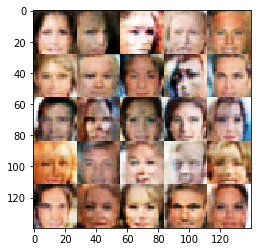

Epoch 0/1... Discriminator Loss: 1.2930... Generator Loss: 0.6053
Epoch 0/1... Discriminator Loss: 1.4314... Generator Loss: 0.6541
Epoch 0/1... Discriminator Loss: 1.5326... Generator Loss: 0.4271
Epoch 0/1... Discriminator Loss: 1.4494... Generator Loss: 0.4855
Epoch 0/1... Discriminator Loss: 1.4306... Generator Loss: 0.6161
Epoch 0/1... Discriminator Loss: 1.4465... Generator Loss: 0.6343
Epoch 0/1... Discriminator Loss: 1.4175... Generator Loss: 0.4632
Epoch 0/1... Discriminator Loss: 1.4790... Generator Loss: 0.4666
Epoch 0/1... Discriminator Loss: 1.4033... Generator Loss: 0.4521
Epoch 0/1... Discriminator Loss: 1.3732... Generator Loss: 0.6408


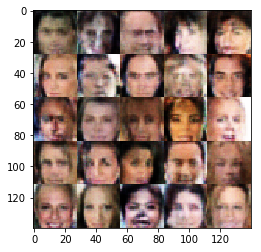

Epoch 0/1... Discriminator Loss: 1.5979... Generator Loss: 0.5459
Epoch 0/1... Discriminator Loss: 1.4300... Generator Loss: 0.4843
Epoch 0/1... Discriminator Loss: 1.3811... Generator Loss: 0.4883
Epoch 0/1... Discriminator Loss: 1.3183... Generator Loss: 0.5826
Epoch 0/1... Discriminator Loss: 1.4057... Generator Loss: 0.5639
Epoch 0/1... Discriminator Loss: 1.4436... Generator Loss: 0.5057
Epoch 0/1... Discriminator Loss: 1.4910... Generator Loss: 0.6666
Epoch 0/1... Discriminator Loss: 1.4469... Generator Loss: 0.5171
Epoch 0/1... Discriminator Loss: 1.3136... Generator Loss: 0.6396
Epoch 0/1... Discriminator Loss: 1.5372... Generator Loss: 0.4401


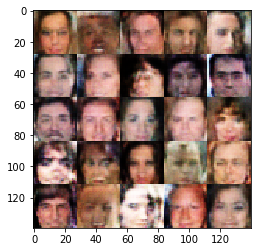

Epoch 0/1... Discriminator Loss: 1.3930... Generator Loss: 0.4681
Epoch 0/1... Discriminator Loss: 1.6172... Generator Loss: 0.4234
Epoch 0/1... Discriminator Loss: 1.3612... Generator Loss: 0.5441
Epoch 0/1... Discriminator Loss: 1.4842... Generator Loss: 0.4488
Epoch 0/1... Discriminator Loss: 1.3851... Generator Loss: 0.4720
Epoch 0/1... Discriminator Loss: 1.3437... Generator Loss: 0.6697
Epoch 0/1... Discriminator Loss: 1.5668... Generator Loss: 0.4559
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.5237
Epoch 0/1... Discriminator Loss: 1.5129... Generator Loss: 0.5854
Epoch 0/1... Discriminator Loss: 1.4647... Generator Loss: 0.5127


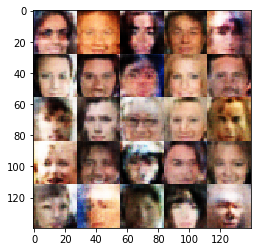

Epoch 0/1... Discriminator Loss: 1.6198... Generator Loss: 0.4333
Epoch 0/1... Discriminator Loss: 1.5607... Generator Loss: 0.4071
Epoch 0/1... Discriminator Loss: 1.4910... Generator Loss: 0.6334
Epoch 0/1... Discriminator Loss: 1.1531... Generator Loss: 0.7085
Epoch 0/1... Discriminator Loss: 1.6386... Generator Loss: 0.3383
Epoch 0/1... Discriminator Loss: 1.4179... Generator Loss: 0.5333
Epoch 0/1... Discriminator Loss: 1.2809... Generator Loss: 0.5637
Epoch 0/1... Discriminator Loss: 1.4397... Generator Loss: 0.5210
Epoch 0/1... Discriminator Loss: 1.4021... Generator Loss: 0.6188
Epoch 0/1... Discriminator Loss: 1.5197... Generator Loss: 0.5182


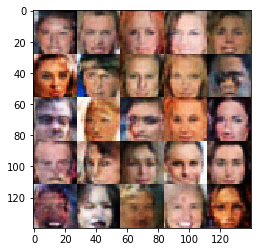

Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 0.5224
Epoch 0/1... Discriminator Loss: 1.5945... Generator Loss: 0.4692
Epoch 0/1... Discriminator Loss: 1.2414... Generator Loss: 0.5384
Epoch 0/1... Discriminator Loss: 1.5624... Generator Loss: 0.4094
Epoch 0/1... Discriminator Loss: 1.4179... Generator Loss: 0.4225
Epoch 0/1... Discriminator Loss: 1.3314... Generator Loss: 0.5516
Epoch 0/1... Discriminator Loss: 1.0063... Generator Loss: 0.8797
Epoch 0/1... Discriminator Loss: 1.3944... Generator Loss: 0.6421
Epoch 0/1... Discriminator Loss: 1.3388... Generator Loss: 0.5367
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 0.4513


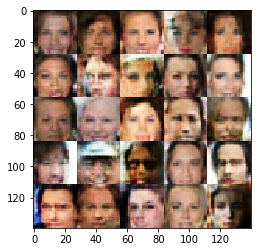

Epoch 0/1... Discriminator Loss: 1.4035... Generator Loss: 0.6601
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.5698
Epoch 0/1... Discriminator Loss: 1.6172... Generator Loss: 0.3768
Epoch 0/1... Discriminator Loss: 1.2306... Generator Loss: 0.6875
Epoch 0/1... Discriminator Loss: 1.3722... Generator Loss: 0.4919
Epoch 0/1... Discriminator Loss: 1.2415... Generator Loss: 0.5916
Epoch 0/1... Discriminator Loss: 1.6359... Generator Loss: 0.4204
Epoch 0/1... Discriminator Loss: 1.1368... Generator Loss: 0.7274
Epoch 0/1... Discriminator Loss: 1.4582... Generator Loss: 0.4724
Epoch 0/1... Discriminator Loss: 1.5191... Generator Loss: 0.4237


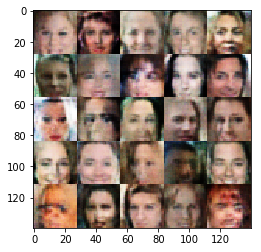

Epoch 0/1... Discriminator Loss: 1.6565... Generator Loss: 0.3143
Epoch 0/1... Discriminator Loss: 1.4153... Generator Loss: 0.4628
Epoch 0/1... Discriminator Loss: 1.4262... Generator Loss: 0.5300
Epoch 0/1... Discriminator Loss: 1.4627... Generator Loss: 0.5256
Epoch 0/1... Discriminator Loss: 1.4737... Generator Loss: 0.6413
Epoch 0/1... Discriminator Loss: 1.2757... Generator Loss: 0.6872
Epoch 0/1... Discriminator Loss: 1.5599... Generator Loss: 0.4970
Epoch 0/1... Discriminator Loss: 1.3275... Generator Loss: 0.5355
Epoch 0/1... Discriminator Loss: 1.3864... Generator Loss: 0.5356
Epoch 0/1... Discriminator Loss: 1.2941... Generator Loss: 0.6347


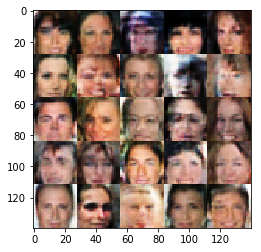

Epoch 0/1... Discriminator Loss: 1.2942... Generator Loss: 0.5390
Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.4485
Epoch 0/1... Discriminator Loss: 1.4561... Generator Loss: 0.4835
Epoch 0/1... Discriminator Loss: 1.5627... Generator Loss: 0.5069
Epoch 0/1... Discriminator Loss: 0.9367... Generator Loss: 0.9058
Epoch 0/1... Discriminator Loss: 1.4547... Generator Loss: 0.4114
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 0.6712
Epoch 0/1... Discriminator Loss: 1.4373... Generator Loss: 0.5420
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.7842
Epoch 0/1... Discriminator Loss: 1.3994... Generator Loss: 0.4993


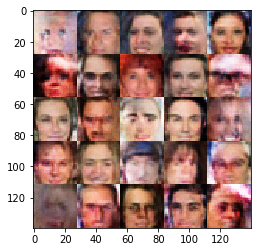

Epoch 0/1... Discriminator Loss: 1.3939... Generator Loss: 0.5253
Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.4725
Epoch 0/1... Discriminator Loss: 1.5406... Generator Loss: 0.4529
Epoch 0/1... Discriminator Loss: 1.2074... Generator Loss: 0.6260
Epoch 0/1... Discriminator Loss: 1.3820... Generator Loss: 0.5388
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 0.7057
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.5366
Epoch 0/1... Discriminator Loss: 1.4400... Generator Loss: 0.4519
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.5721
Epoch 0/1... Discriminator Loss: 1.4144... Generator Loss: 0.5999


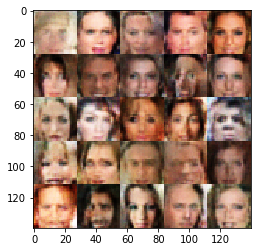

Epoch 0/1... Discriminator Loss: 1.5820... Generator Loss: 0.4288
Epoch 0/1... Discriminator Loss: 1.4607... Generator Loss: 0.4138
Epoch 0/1... Discriminator Loss: 1.4863... Generator Loss: 0.4020
Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 0.5893
Epoch 0/1... Discriminator Loss: 1.5817... Generator Loss: 0.4617
Epoch 0/1... Discriminator Loss: 1.3141... Generator Loss: 0.5389
Epoch 0/1... Discriminator Loss: 1.2562... Generator Loss: 0.5687
Epoch 0/1... Discriminator Loss: 1.4725... Generator Loss: 0.4547
Epoch 0/1... Discriminator Loss: 1.3609... Generator Loss: 0.5186
Epoch 0/1... Discriminator Loss: 1.6208... Generator Loss: 0.3431


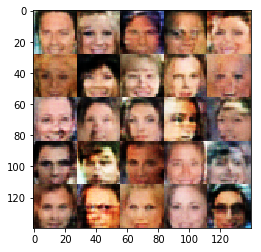

Epoch 0/1... Discriminator Loss: 1.4052... Generator Loss: 0.5190
Epoch 0/1... Discriminator Loss: 1.3448... Generator Loss: 0.4727
Epoch 0/1... Discriminator Loss: 1.4778... Generator Loss: 0.5159
Epoch 0/1... Discriminator Loss: 1.5421... Generator Loss: 0.4082
Epoch 0/1... Discriminator Loss: 1.3622... Generator Loss: 0.5127
Epoch 0/1... Discriminator Loss: 1.1179... Generator Loss: 0.8411
Epoch 0/1... Discriminator Loss: 1.4465... Generator Loss: 0.4615
Epoch 0/1... Discriminator Loss: 1.4880... Generator Loss: 0.3680
Epoch 0/1... Discriminator Loss: 1.7529... Generator Loss: 0.3258
Epoch 0/1... Discriminator Loss: 1.4468... Generator Loss: 0.5020


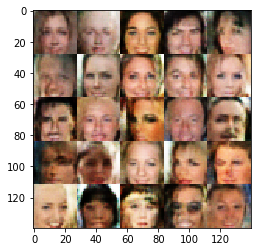

Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 0.4750
Epoch 0/1... Discriminator Loss: 1.5524... Generator Loss: 0.4098
Epoch 0/1... Discriminator Loss: 1.6085... Generator Loss: 0.3722
Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.5321
Epoch 0/1... Discriminator Loss: 1.7642... Generator Loss: 0.3648
Epoch 0/1... Discriminator Loss: 1.6404... Generator Loss: 0.4167


In [27]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.